In [224]:
# import packages 

import pandas as pd
import numpy as np 


import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

from nltk.corpus import stopwords

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
import os, glob, sys, re, os, time
from sklearn import metrics
from sklearn.model_selection import cross_val_score

### Training Data Cleaning

In [225]:
# read in excel file
reddit = pd.read_excel("Relevant Reddit Posts.xlsx")

In [226]:
reddit.head()

,Text,Subreddit,Title,Author,Location,Created,Link,Theme,Protected Grounds
0,"When I got on the phone with them, they told m...",AskHR,Help!-racist comment said at work-complaint fi...,NaN,NaN,Mar 29 2020,https://www.reddit.com/r/AskHR/comments/frhe4y...,"racist coworker, micro-aggression, HR trouble","Race, Black"
1,I work at a small office. Most of us are clear...,Work,Should I ask HR for diversity training?,NaN,NaN,Oct 04 2018,https://www.reddit.com/r/work/comments/9ldyb5/...,"racist coworker, HR trouble, BLM","Race, Black"
2,Excited to have become the diversity and inclu...,AskHR,Have become diversity and inclusion lead at wo...,NaN,[UK],Jul 24 2020,https://www.reddit.com/r/AskHR/comments/hxaj1y...,"activist action, BLM, mega-threat","Race, Black"
3,Disclaimer I’m not posting this to shame my co...,AskHR,I shadowed a Co worker during a customer faced...,NaN,Houston Texas,Jul 20 2020,https://www.reddit.com/r/AskHR/comments/hkobea...,"HR trouble, racist coworker","Race, Asian, Black"
4,Hello fellow HR people! This is a weird questi...,AskHR,Washington State General Strike,NaN,Washington,Jun 09 2020,https://www.reddit.com/r/AskHR/comments/gzugri...,"activist action, HR trouble, BLM, mega-threat",Race


In [227]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 9 columns):
Text                 94 non-null object
Subreddit            94 non-null object
Title                94 non-null object
Author               71 non-null object
Location             11 non-null object
Created              93 non-null object
Link                 22 non-null object
Theme                93 non-null object
Protected Grounds    92 non-null object
dtypes: object(9)
memory usage: 6.7+ KB


In [228]:
reddit = reddit.rename(columns = {'Subreddit ': 'Subreddit'})

In [229]:
# remove whitespace before any themes after the comma 
reddit['Theme'] = reddit['Theme'].str.replace(", ", ",")

In [230]:
# generate dummies variables from unique values from the theme
topics = reddit['Theme'].str.get_dummies(',')
topics.head(20)

,BLM,HR trouble,activism action,activist action,blm,discrimination,diversity,iscrimination,mega-threat,micro-aggression,racist coworker
0,0,1,0,0,0,0,0,0,0,1,1
1,1,1,0,0,0,0,0,0,0,0,1
2,1,0,0,1,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0,0,1
4,1,1,0,1,0,0,0,0,1,0,0
5,1,0,0,1,0,0,0,0,1,0,0
6,1,1,0,1,0,0,0,0,1,0,0
7,1,1,0,0,0,0,0,0,1,0,1
8,1,1,0,1,0,0,0,0,0,1,0
9,1,1,0,0,0,0,0,0,1,0,1


In [231]:
# combine BLM and blm; activism action and activist action columns
topics['BLM'] = topics['BLM'] + topics['blm']

topics['activist action'] = topics['activism action'] + topics['activist action']

topics['discrimination'] = topics['discrimination'] + topics['iscrimination']

topics_clean = topics.drop(columns = ['blm', 'activism action', 'iscrimination'])

topics_clean.head()

,BLM,HR trouble,activist action,discrimination,diversity,mega-threat,micro-aggression,racist coworker
0,0,1,0,0,0,0,1,1
1,1,1,0,0,0,0,0,1
2,1,0,1,0,0,1,0,0
3,0,1,0,0,0,0,0,1
4,1,1,1,0,0,1,0,0


In [232]:
# rename theme values to topic names
topics_clean = topics_clean.rename(columns = {col: 'topic'+'_{}'.format(col) for col in topics.columns}) 

topics_clean.head()

,topic_BLM,topic_HR trouble,topic_activist action,topic_discrimination,topic_diversity,topic_mega-threat,topic_micro-aggression,topic_racist coworker
0,0,1,0,0,0,0,1,1
1,1,1,0,0,0,0,0,1
2,1,0,1,0,0,1,0,0
3,0,1,0,0,0,0,0,1
4,1,1,1,0,0,1,0,0


In [233]:
# now we concate topics_clean back to reddit df 

reddit = reddit.join(topics_clean)
reddit.head()

,Text,Subreddit,Title,Author,Location,Created,Link,Theme,Protected Grounds,topic_BLM,topic_HR trouble,topic_activist action,topic_discrimination,topic_diversity,topic_mega-threat,topic_micro-aggression,topic_racist coworker
0,"When I got on the phone with them, they told m...",AskHR,Help!-racist comment said at work-complaint fi...,NaN,NaN,Mar 29 2020,https://www.reddit.com/r/AskHR/comments/frhe4y...,"racist coworker,micro-aggression,HR trouble","Race, Black",0,1,0,0,0,0,1,1
1,I work at a small office. Most of us are clear...,Work,Should I ask HR for diversity training?,NaN,NaN,Oct 04 2018,https://www.reddit.com/r/work/comments/9ldyb5/...,"racist coworker,HR trouble,BLM","Race, Black",1,1,0,0,0,0,0,1
2,Excited to have become the diversity and inclu...,AskHR,Have become diversity and inclusion lead at wo...,NaN,[UK],Jul 24 2020,https://www.reddit.com/r/AskHR/comments/hxaj1y...,"activist action,BLM,mega-threat","Race, Black",1,0,1,0,0,1,0,0
3,Disclaimer I’m not posting this to shame my co...,AskHR,I shadowed a Co worker during a customer faced...,NaN,Houston Texas,Jul 20 2020,https://www.reddit.com/r/AskHR/comments/hkobea...,"HR trouble,racist coworker","Race, Asian, Black",0,1,0,0,0,0,0,1
4,Hello fellow HR people! This is a weird questi...,AskHR,Washington State General Strike,NaN,Washington,Jun 09 2020,https://www.reddit.com/r/AskHR/comments/gzugri...,"activist action,HR trouble,BLM,mega-threat",Race,1,1,1,0,0,1,0,0


In [234]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 17 columns):
Text                      94 non-null object
Subreddit                 94 non-null object
Title                     94 non-null object
Author                    71 non-null object
Location                  11 non-null object
Created                   93 non-null object
Link                      22 non-null object
Theme                     93 non-null object
Protected Grounds         92 non-null object
topic_BLM                 94 non-null int64
topic_HR trouble          94 non-null int64
topic_activist action     94 non-null int64
topic_discrimination      94 non-null int64
topic_diversity           94 non-null int64
topic_mega-threat         94 non-null int64
topic_micro-aggression    94 non-null int64
topic_racist coworker     94 non-null int64
dtypes: int64(8), object(9)
memory usage: 12.6+ KB


### Data Cleaning - Text analysis 
- having post text as features using `CountVectorizer`

In [235]:
stop_words = stopwords.words('english')

stop_words.extend(['know', 'make', 'need', 'see', 'say', 'think', 'from', 'subject', 're', 'edu', 'use', 'people', 'going', 'even', 'just', 'still', 'really', 'many', 'thats', 'thing', 'actually', 'one', 'get' ])
stop_words.extend(['subreddit', 'im','dont','have', 'has', 'had', 'are', 'is', 'was', 'were', 'lot', 'lots', 'some', 'can', 'could', 'will', 'would', 'must', 'should', 'also', 'may', 'be'])
stop_words.extend(['question', 'ask','discuss','redditor', 'reddit', 'post','dedicate', 'discussion'])
vect_act = CountVectorizer(lowercase=False, min_df=50, max_df=0.6)


In [236]:
# removes numbers from text
def preprocess_text(text):
    text = re.sub(r'\d+', '', text)
    return text

vect_text = CountVectorizer(min_df=3, max_df=0.9, ngram_range=(1, 3), stop_words=stop_words, 
                            preprocessor=preprocess_text)

In [237]:
text = reddit.Text
text_dtm = vect_text.fit_transform(text)
df_text = pd.DataFrame(text_dtm.toarray())
n_text=len(df_text. columns)+1
dict(zip(list(range(n_text)), vect_text.get_feature_names()))
df_text.rename(columns=dict(zip(list(range(n_text)), vect_text.get_feature_names())), inplace=True)


In [238]:
other = reddit[list(topics_clean.columns)]

In [239]:
DF = pd.concat([other, df_text], axis=1)
DF.head()

,topic_BLM,topic_HR trouble,topic_activist action,topic_discrimination,topic_diversity,topic_mega-threat,topic_micro-aggression,topic_racist coworker,As,BLM,...,world,worth,write,wrong,year,years,yes,yet,younger,youâ
0,0,1,0,0,0,0,1,1,0,0,...,0,0,1,1,0,0,5,0,0,0
1,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


#### Topic_BLM

In [240]:
X = df_text
y = other['topic_BLM']

seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

# we don't have stratify parameter is because The stratify parameter set it to split data in a way to allocate 
# test_size amount of data to each class. In this case, you don't have sufficient class labels of one of your classes 
# to keep the data splitting ratio equal to test_size.

#### SVM model


CPU times: user 12.7 ms, sys: 226 µs, total: 13 ms
Wall time: 13 ms
Accuracy: 62.07%
              precision    recall  f1-score   support

           0       0.63      0.94      0.76        18
           1       0.50      0.09      0.15        11

   micro avg       0.62      0.62      0.62        29
   macro avg       0.56      0.52      0.45        29
weighted avg       0.58      0.62      0.53        29



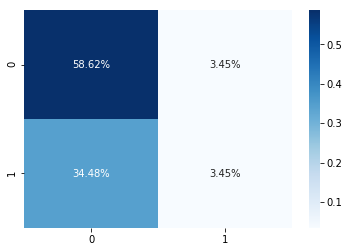

In [241]:
# import and instantiate a SVM model
from sklearn.svm import SVC

model = SVC(C=1, kernel='linear', probability=True )

model.fit(X_train, y_train)
%time model.fit(X_train, y_train)

# make predictions for test data
#%time y_pred = model.predict(X_test)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


cm = metrics.confusion_matrix(y_test, y_pred)
print(metrics.classification_report(y_test, y_pred))

sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

#### Random Forest

CPU times: user 594 ms, sys: 277 ms, total: 871 ms
Wall time: 770 ms
CPU times: user 69.1 ms, sys: 15.1 ms, total: 84.2 ms
Wall time: 111 ms
Accuracy: 65.52%
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        18
           1       1.00      0.09      0.17        11

   micro avg       0.66      0.66      0.66        29
   macro avg       0.82      0.55      0.47        29
weighted avg       0.78      0.66      0.55        29



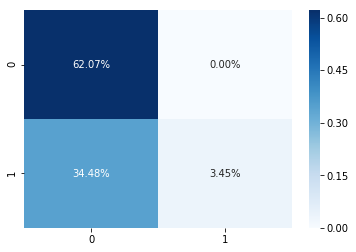

In [242]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators= 500, n_jobs=-1, max_depth=5, random_state=8, class_weight='balanced')

%time model.fit(X_train, y_train)
%time y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
cm=metrics.confusion_matrix(y_test, y_pred)
print(metrics.classification_report(y_test, y_pred))
cm
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

#### Multinomial Naive Bayes Model


CPU times: user 3.2 ms, sys: 1.97 ms, total: 5.17 ms
Wall time: 3.97 ms
CPU times: user 3.11 ms, sys: 101 µs, total: 3.21 ms
Wall time: 2.1 ms
Accuracy: 72.41%
              precision    recall  f1-score   support

           0       0.73      0.89      0.80        18
           1       0.71      0.45      0.56        11

   micro avg       0.72      0.72      0.72        29
   macro avg       0.72      0.67      0.68        29
weighted avg       0.72      0.72      0.71        29



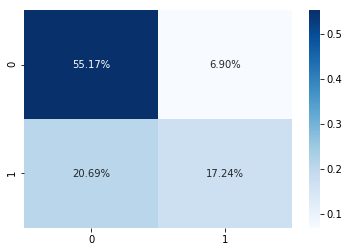

In [243]:
# fit a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB(alpha = 1)
%time model.fit(X_train, y_train)

# make predictions for test data
%time y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

cm = metrics.confusion_matrix(y_test, y_pred)
print(metrics.classification_report(y_test, y_pred))

sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

### Multilabel Classification

In [244]:
# Random forest
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import roc_auc_score

X1 = df_text
y1 = other
seed = 42
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=seed)

forest = RandomForestClassifier(n_estimators= 500, n_jobs=-1, max_depth=5, random_state=8, class_weight='balanced')

model_multi = MultiOutputClassifier(forest, n_jobs=-1)

%time model_multi.fit(X_train1, y_train1)

# make predictions for test data
%time y_pred1 = model_multi.predict(X_test1)


# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
y_test_p = y_test1.values

d = {}

for i in range(len(y1.columns)):
    d["auc_{0}".format(y1.columns[i])] = roc_auc_score(y_test_p[:,i], y_pred1[:,i])

d

CPU times: user 477 ms, sys: 97.8 ms, total: 575 ms
Wall time: 5.96 s
CPU times: user 1.98 s, sys: 62.2 ms, total: 2.04 s
Wall time: 2.34 s


{'auc_topic_BLM': 0.5454545454545454,
 'auc_topic_HR trouble': 0.6994949494949495,
 'auc_topic_activist action': 0.5714285714285714,
 'auc_topic_discrimination': 0.7559523809523809,
 'auc_topic_diversity': 0.5833333333333334,
 'auc_topic_mega-threat': 0.5615942028985508,
 'auc_topic_micro-aggression': 0.5,
 'auc_topic_racist coworker': 0.5}

In [245]:
# classification_report
from sklearn.metrics import classification_report

cr = {}

for i in range(len(y1.columns)):
     print("classfication report for\t"+"{}\n".format(y1.columns[i])+ classification_report(y_test_p[:,i], y_pred1[:,i]))

print()

classfication report for	topic_BLM
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        18
           1       1.00      0.09      0.17        11

   micro avg       0.66      0.66      0.66        29
   macro avg       0.82      0.55      0.47        29
weighted avg       0.78      0.66      0.55        29

classfication report for	topic_HR trouble
              precision    recall  f1-score   support

           0       0.74      0.94      0.83        18
           1       0.83      0.45      0.59        11

   micro avg       0.76      0.76      0.76        29
   macro avg       0.79      0.70      0.71        29
weighted avg       0.77      0.76      0.74        29

classfication report for	topic_activist action
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        22
           1       1.00      0.14      0.25         7

   micro avg       0.79      0.79      0.79        29
   m

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/p

In [246]:
# MNB
from sklearn.naive_bayes import MultinomialNB

X1 = df_text
y1 = other

seed = 42
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=seed)


mnb = MultinomialNB(alpha = 1)

model_multi = MultiOutputClassifier(mnb, n_jobs=-1)

%time model_multi.fit(X_train1, y_train1)

# make predictions for test data
%time y_pred1 = model_multi.predict(X_test1)


# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
y_test_p = y_test1.values

d = {}

for i in range(len(y1.columns)):
    d["auc_{0}".format(y1.columns[i])] = roc_auc_score(y_test_p[:,i], y_pred1[:,i])

d

CPU times: user 19.4 ms, sys: 3.83 ms, total: 23.3 ms
Wall time: 46.8 ms
CPU times: user 11.9 ms, sys: 1.86 ms, total: 13.8 ms
Wall time: 12.9 ms


{'auc_topic_BLM': 0.6717171717171717,
 'auc_topic_HR trouble': 0.8333333333333334,
 'auc_topic_activist action': 0.577922077922078,
 'auc_topic_discrimination': 0.6845238095238095,
 'auc_topic_diversity': 0.681159420289855,
 'auc_topic_mega-threat': 0.6014492753623187,
 'auc_topic_micro-aggression': 0.9642857142857143,
 'auc_topic_racist coworker': 0.5421052631578948}

In [247]:
from sklearn.metrics import classification_report

cr = {}

for i in range(len(y1.columns)):
     print("classfication report for\t"+"{}\n".format(y1.columns[i])+ classification_report(y_test_p[:,i], y_pred1[:,i]))

print()

classfication report for	topic_BLM
              precision    recall  f1-score   support

           0       0.73      0.89      0.80        18
           1       0.71      0.45      0.56        11

   micro avg       0.72      0.72      0.72        29
   macro avg       0.72      0.67      0.68        29
weighted avg       0.72      0.72      0.71        29

classfication report for	topic_HR trouble
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        18
           1       0.65      1.00      0.79        11

   micro avg       0.79      0.79      0.79        29
   macro avg       0.82      0.83      0.79        29
weighted avg       0.87      0.79      0.79        29

classfication report for	topic_activist action
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        22
           1       0.33      0.43      0.38         7

   micro avg       0.66      0.66      0.66        29
   m

#### Conclusion
It seems that MultinomialNB model does a better job at predicting posts that are BLM related; both in terms of accuracy measures and precision and recall measures. 

### Predicting Larger Dataset

In [248]:
df2_ = pd.read_csv("Reddit2k.csv")
df2_.head()

,text,subreddit,title,author,created
0,Yep. So far i would say if worst came to worst...,2020PoliceBrutality,Can we talk about this new âOperation Legend...,tacoim,2020-07-23 2:25
1,I feel so much fear and anxiety all the time. ...,2020PoliceBrutality,I need peace in my family. Anyone have any art...,Cham-Clowder,2020-07-20 11:04
2,Portland is going to skyrocket to the top agai...,2020PoliceBrutality,Wanted to give y'all an update on our count. C...,helicopter_corgi_mom,2020-07-18 0:34
3,Use the bubbling hate it generates to fund the...,2020PoliceBrutality,How do you cope with the emotions of subscribi...,seraphsrage,2020-07-12 23:24
4,I have recently rediscovered metal music. I lo...,2020PoliceBrutality,How do you cope with the emotions of subscribi...,kpolar,2020-07-15 7:49


# Import Manually Corrected Prediction

In [301]:
df_pm = pd.read_excel("Reddit_p5.xlsx")

df_pm.head()

,text,subreddit,title,author,created,topic_BLM
0,It's uncanny. They unnecessarily escalate and ...,2020PoliceBrutality,Black mother and four children were handcuffed...,asunnyweb,2020-08-05 4:46,1
1,I would like to offer my services in training ...,2020PoliceBrutality,Black mother and four children were handcuffed...,ncman424,2020-08-06 2:32,1
2,They are on the wrong side. Doesn't matter if ...,2020PoliceBrutality,Black mother and four children were handcuffed...,LordDarkSteel,2020-08-04 16:38,1
3,Ahahahaha. Cops are garbage people. Not to be ...,2020PoliceBrutality,Black mother and four children were handcuffed...,Gardenfarm,2020-08-04 21:30,1
4,Yes letâs please continue to sue the PD so m...,2020PoliceBrutality,Black mother and four children were handcuffed...,Funk-E-Buttlovin,2020-08-04 20:12,1


In [289]:
df_pm.columns = map(lambda x: str(x).title(), df_pm.columns)

df_pm = df_pm.rename(columns = {"Topic_Blm" : "topic_BLM"})
df_pm.head()

,Text,Subreddit,Title,Author,Created,topic_BLM
0,"Hi guys, donât know what added value I could...",2020PoliceBrutality,[Mega Thread] Compilation of police brutality ...,zoran-grbic,2020-06-01 9:08,0
1,I just watched about ten of these. I have to s...,2020PoliceBrutality,[Mega Thread] Compilation of police brutality ...,wroach16,2020-06-01 13:10,1
2,"Hey, thanks for doing that! Like u/wet4 said, ...",2020PoliceBrutality,[Mega Thread] Compilation of police brutality ...,flybypost,2020-05-31 17:21,0
3,"You know what, bitch?You are never to use anyt...",2020PoliceBrutality,[Mega Thread] Compilation of police brutality ...,LawyerMortyHater,2020-06-02 3:00,0
4,That'd what I thought first time I saw it. We ...,2020PoliceBrutality,[Mega Thread] Compilation of police brutality ...,fangirlsqueee,2020-06-01 0:21,1


In [290]:
df_pm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
Text         50 non-null object
Subreddit    50 non-null object
Title        50 non-null object
Author       49 non-null object
Created      50 non-null object
topic_BLM    50 non-null int64
dtypes: int64(1), object(5)
memory usage: 2.4+ KB


In [291]:
reddit.head()

,Author,Created,Subreddit,Text,Title,topic_BLM
0,NaN,Mar 29 2020,AskHR,"When I got on the phone with them, they told m...",Help!-racist comment said at work-complaint fi...,0
1,NaN,Oct 04 2018,Work,I work at a small office. Most of us are clear...,Should I ask HR for diversity training?,1
2,NaN,Jul 24 2020,AskHR,Excited to have become the diversity and inclu...,Have become diversity and inclusion lead at wo...,1
3,NaN,Jul 20 2020,AskHR,Disclaimer I’m not posting this to shame my co...,I shadowed a Co worker during a customer faced...,0
4,NaN,Jun 09 2020,AskHR,Hello fellow HR people! This is a weird questi...,Washington State General Strike,1


In [292]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244 entries, 0 to 49
Data columns (total 6 columns):
Author       219 non-null object
Created      243 non-null object
Subreddit    244 non-null object
Text         244 non-null object
Title        244 non-null object
topic_BLM    244 non-null int64
dtypes: int64(1), object(5)
memory usage: 13.3+ KB


In [293]:
cols1 = list(set(reddit.columns).intersection(df_pm.columns))
reddit_ = reddit[cols1]
reddit_.head()

,Author,Created,topic_BLM,Text,Title,Subreddit
0,NaN,Mar 29 2020,0,"When I got on the phone with them, they told m...",Help!-racist comment said at work-complaint fi...,AskHR
1,NaN,Oct 04 2018,1,I work at a small office. Most of us are clear...,Should I ask HR for diversity training?,Work
2,NaN,Jul 24 2020,1,Excited to have become the diversity and inclu...,Have become diversity and inclusion lead at wo...,AskHR
3,NaN,Jul 20 2020,0,Disclaimer I’m not posting this to shame my co...,I shadowed a Co worker during a customer faced...,AskHR
4,NaN,Jun 09 2020,1,Hello fellow HR people! This is a weird questi...,Washington State General Strike,AskHR


In [294]:
reddit_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244 entries, 0 to 49
Data columns (total 6 columns):
Author       219 non-null object
Created      243 non-null object
topic_BLM    244 non-null int64
Text         244 non-null object
Title        244 non-null object
Subreddit    244 non-null object
dtypes: int64(1), object(5)
memory usage: 13.3+ KB


In [295]:
reddit = pd.concat([reddit_, df_pm], axis = 0, sort = True)
reddit.head()

,Author,Created,Subreddit,Text,Title,topic_BLM
0,NaN,Mar 29 2020,AskHR,"When I got on the phone with them, they told m...",Help!-racist comment said at work-complaint fi...,0
1,NaN,Oct 04 2018,Work,I work at a small office. Most of us are clear...,Should I ask HR for diversity training?,1
2,NaN,Jul 24 2020,AskHR,Excited to have become the diversity and inclu...,Have become diversity and inclusion lead at wo...,1
3,NaN,Jul 20 2020,AskHR,Disclaimer I’m not posting this to shame my co...,I shadowed a Co worker during a customer faced...,0
4,NaN,Jun 09 2020,AskHR,Hello fellow HR people! This is a weird questi...,Washington State General Strike,1


In [296]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294 entries, 0 to 49
Data columns (total 6 columns):
Author       268 non-null object
Created      293 non-null object
Subreddit    294 non-null object
Text         294 non-null object
Title        294 non-null object
topic_BLM    294 non-null int64
dtypes: int64(1), object(5)
memory usage: 16.1+ KB


## Re-Train Dataset

In [297]:
text = reddit.Text
text_dtm = vect_text.fit_transform(text)
df_text = pd.DataFrame(text_dtm.toarray())
n_text=len(df_text. columns)+1
dict(zip(list(range(n_text)), vect_text.get_feature_names()))
df_text.rename(columns=dict(zip(list(range(n_text)), vect_text.get_feature_names())), inplace=True)

In [298]:
df_text.head()

,All,Also,America,American,And,Are,As,August,BLM,Because,...,write,writing,wrong,www,year,years,yes,yet,younger,youâ
0,0,0,0,2,0,0,0,0,0,0,...,1,0,1,0,0,0,5,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,2,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [299]:
X = df_text
y = reddit['topic_BLM']

seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

CPU times: user 5.43 ms, sys: 3.16 ms, total: 8.6 ms
Wall time: 5.61 ms
CPU times: user 4.38 ms, sys: 335 µs, total: 4.71 ms
Wall time: 1.64 ms
Accuracy: 76.40%
              precision    recall  f1-score   support

           0       0.82      0.65      0.73        43
           1       0.73      0.87      0.79        46

   micro avg       0.76      0.76      0.76        89
   macro avg       0.78      0.76      0.76        89
weighted avg       0.77      0.76      0.76        89



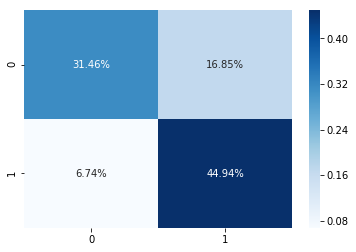

In [300]:
# fit a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB(alpha = 1)
%time model.fit(X_train, y_train)

# make predictions for test data
%time y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

cm = metrics.confusion_matrix(y_test, y_pred)
print(metrics.classification_report(y_test, y_pred))

sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

In [218]:
df2 = df2_.iloc[350:450].reset_index().drop(columns = 'index')
df2.head()

,text,subreddit,title,author,created
0,"Abolish the Police Union, abolish Civil Forfei...",2020PoliceBrutality,Police block off sidewalks and start shooting ...,Gallaga07,2020-06-08 12:20
1,"I don't believe anyone is beyond redemption, b...",2020PoliceBrutality,Police block off sidewalks and start shooting ...,Spadeware,2020-06-08 16:05
2,It's the internet. Censorship is extremely har...,2020PoliceBrutality,Police block off sidewalks and start shooting ...,jojo_31,2020-06-08 10:48
3,"Oh, I thought it would like collapse the throa...",2020PoliceBrutality,Police block off sidewalks and start shooting ...,Maxstrongarm451,2020-06-08 14:53
4,"Thank you, BarackTrudeau, for voting on Vreddi...",2020PoliceBrutality,Police block off sidewalks and start shooting ...,B0tRank,2020-06-08 17:58


In [219]:
text2 = df2.text
text_dtm2 = vect_text.fit_transform(text2)
df_text2 = pd.DataFrame(text_dtm2.toarray())
n_text2 = len(df_text2. columns)+1
dict(zip(list(range(n_text2)), vect_text.get_feature_names()))
df_text2.rename(columns=dict(zip(list(range(n_text2)), vect_text.get_feature_names())), inplace=True)
df_text2.head()

,Also,America,Americans,And,But,Do,Good,He,How,If,...,well,went,whole,wife,wish,without,work,workers,world,youâ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,2,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [220]:
# select overlapping text columns

cols_inter = list(set(df_text.columns).intersection(df_text2.columns))

df_text2_inter = df_text2[cols_inter]


# find df_text complement set

cols_com = list(set(df_text.columns) - set(df_text2.columns))

df_text2_com = pd.DataFrame(0, index=np.arange(len(df_text2)), columns=cols_com, dtype = int)

Xp = pd.concat([df_text2_inter, df_text2_com], axis = 1)
Xp.head()

,whole,less,shit,Good,What,fuck,stop,much,pretty,someone,...,perspective,minority,San,Why,She,serve,co,rather,joke,purpose
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [221]:
y_pred = model.predict(Xp)


df2['topic_BLM'] = pd.Series(y_pred)

df2.head()

,text,subreddit,title,author,created,topic_BLM
0,"Abolish the Police Union, abolish Civil Forfei...",2020PoliceBrutality,Police block off sidewalks and start shooting ...,Gallaga07,2020-06-08 12:20,1
1,"I don't believe anyone is beyond redemption, b...",2020PoliceBrutality,Police block off sidewalks and start shooting ...,Spadeware,2020-06-08 16:05,1
2,It's the internet. Censorship is extremely har...,2020PoliceBrutality,Police block off sidewalks and start shooting ...,jojo_31,2020-06-08 10:48,1
3,"Oh, I thought it would like collapse the throa...",2020PoliceBrutality,Police block off sidewalks and start shooting ...,Maxstrongarm451,2020-06-08 14:53,1
4,"Thank you, BarackTrudeau, for voting on Vreddi...",2020PoliceBrutality,Police block off sidewalks and start shooting ...,B0tRank,2020-06-08 17:58,1


In [222]:
df2['topic_BLM']

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    0
12    1
13    1
14    1
15    1
16    1
17    1
18    0
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
29    1
     ..
70    1
71    1
72    1
73    1
74    1
75    1
76    1
77    1
78    1
79    1
80    1
81    1
82    1
83    1
84    1
85    1
86    1
87    1
88    1
89    1
90    1
91    1
92    1
93    1
94    0
95    1
96    1
97    1
98    1
99    0
Name: topic_BLM, Length: 100, dtype: int64

In [223]:
df2.to_excel("Reddit_p7.xlsx", index = False)

/anaconda3/lib/python3.7/site-packages/xlsxwriter/worksheet.py:912: UserWarning: Ignoring URL 'https://dps.mn.gov/macc/Pages/resources-links.aspxExecutive%20Order%2020-65%20says:b.%20For%20the%20purposes%20of%20this%20Executive%20Order,%20a%20âpublic%20placeâ%20is%20any%20place,%20whether%20on%20privately%20or%20publicly%20owned%20property,%20accessible%20to%20the%20generalpublic,%20including%20but%20not%20limited%20to%20public%20streets%20and%20roads,%20alleys,%20highways,%20driveways,%20sidewalks,%20parks,%20vacant%20lots,%20and%20unsupervised%20property.I%20donât%20know%20if%20itâs%20been%20modified.%20The%20extension%20(20-68)%20was%20removed%20(get%20404)%20-%20it%20existed%20last%20night.' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))
